In [78]:

from numpy.random import seed
seed(123)

from tensorflow.python.framework.random_seed import set_random_seed
set_random_seed(123)


import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("/Users/nouf/Desktop/archive"))
from sklearn.model_selection import train_test_split



['.DS_Store', 'dataA', 'dataB', 'dataE', 'dataD', 'dataC']


In [79]:
image_path = '/Users/nouf/Desktop/archive/dataA/dataA/CameraRGB/'
mask_path = '/Users/nouf/Desktop/archive/dataA/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [80]:
X = image_list
Y = mask_list

In [81]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.2)

In [82]:
def read_imageMask(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128, 128), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (128, 128), method='nearest')
    
    return img, mask

In [83]:
def data_generator(image_paths, mask_paths, batch_size):
    images = tf.constant(image_paths)
    masks = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_imageMask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().shuffle(500).batch(batch_size)
    
    return dataset

In [84]:
train_generator = data_generator(X_train, Y_train, 32)
val_generator = data_generator(X_val, Y_val, 32)
test_generator = data_generator(X_test, Y_test, 32)

In [85]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [86]:
from tensorflow_examples.models.pix2pix import pix2pix

In [87]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [88]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [90]:
import tensorflow as tf

In [91]:
OUTPUT_CLASSES = 13

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
from tensorflow.keras.callbacks import EarlyStopping

In [93]:
earlystopping = EarlyStopping(monitor='val_loss', patience= 5)

In [95]:
history = model.fit(train_generator, validation_data=val_generator,epochs=20,
                    verbose = 1, batch_size=16,
                    callbacks=[earlystopping])

Epoch 1/20
25/25 [==============================] - 25s 1s/step - loss: 0.4051 - accuracy: 0.9063 - val_loss: 0.4544 - val_accuracy: 0.8768
Epoch 2/20
25/25 [==============================] - 27s 1s/step - loss: 0.3177 - accuracy: 0.9181 - val_loss: 0.3919 - val_accuracy: 0.8952
Epoch 3/20
25/25 [==============================] - 26s 1s/step - loss: 0.2717 - accuracy: 0.9259 - val_loss: 0.3672 - val_accuracy: 0.9027
Epoch 4/20
25/25 [==============================] - 25s 1s/step - loss: 0.2399 - accuracy: 0.9318 - val_loss: 0.3226 - val_accuracy: 0.9172
Epoch 5/20
25/25 [==============================] - 25s 1s/step - loss: 0.2171 - accuracy: 0.9366 - val_loss: 0.3051 - val_accuracy: 0.9192
Epoch 6/20
25/25 [==============================] - 27s 1s/step - loss: 0.1976 - accuracy: 0.9413 - val_loss: 0.2794 - val_accuracy: 0.9255
Epoch 7/20
25/25 [==============================] - 25s 1s/step - loss: 0.1841 - accuracy: 0.9444 - val_loss: 0.2524 - val_accuracy: 0.9290
Epoch 8/20
25/25 [==

In [96]:
train_loss, train_accuracy = model.evaluate(train_generator, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(val_generator, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = 32)

2/2 [==============================] - 1s 138ms/step - loss: 0.1424 - accuracy: 0.9537


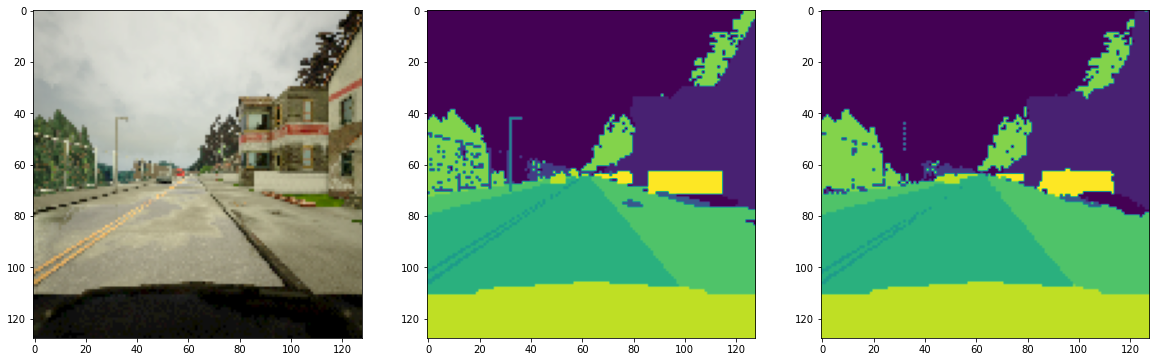

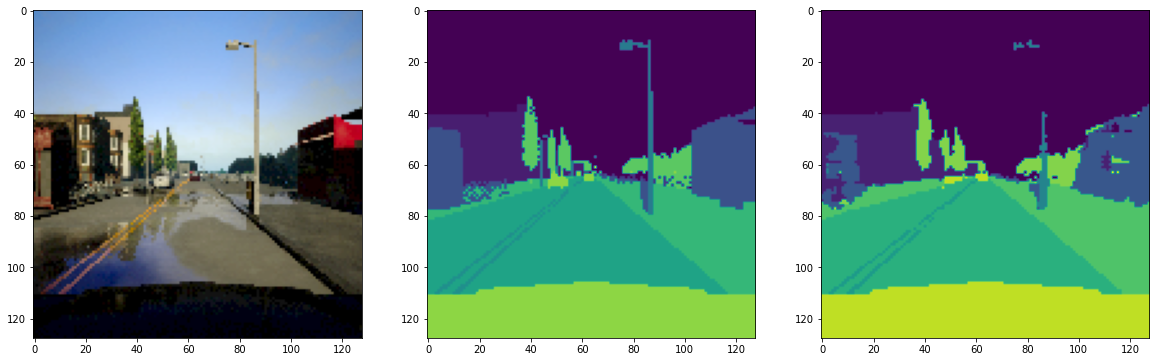

In [97]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))